In [1]:
# * * * * * * * * * * * * * * * *
# Configuration
# * * * * * * * * * * * * * * * *
EXPERIMENT_NUM='7'

DATASET_DIR = '/workspace/datasets'
OUTPUT_DIR = '/workspace/outputs'

TARGET_METRIC = 'combined'
SAMPLE_SIZE=2500

DEVICE = "cpu"

LATENT_DIM=4
BATCH_SIZE=200
EPOCHS=100
BETA=0.2
LEARNING_RATE=1e-3
GAMMA=0.1

INPUT_DIM=(1,120)

In [2]:
import os
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchinfo import summary

from lunar_vae import VAE, train, SampleLatentSpace, VisualizeLatentSpace
from utils import (
    CollectStatisticsFromProfilesV1,
    ConvertProfileListToCsv,
    CreateProfileSubset,
    GenerateDensityPlot,
    GetDataMetrics,
    GetMeanLatentValues,
    LoadProfileList,
    LoadTemperatureDataV1,
    PlotHistograms,
    PlotComparativeHistograms,
    PlotLosses,
    PrintAndLog,
    SaveLossesToCSV,
    SetupOutputDir,
    SplitAndNormalizeData,
)

# * * * * * * * * * * * * * * * *
# Setting Variables
# * * * * * * * * * * * * * * * *
PROFILES_DIR = os.path.join(DATASET_DIR, f'profiles-v1', f'profiles-v1-jsons')
ORIGINAL_PROFILE_LIST_JSON = '/workspace/outputs/profiles-v1/profiles_v1_experiment_2_20250326_0344/profile_list_v1_in_range.json'
LABEL = f'profiles_v1_experiment_{EXPERIMENT_NUM}'
MAX_TEMP_PROFILE_LIST = '/workspace/outputs/profiles_v1_experiment_3_20250331_0128/profile_list_v1_max_temp_2500.json'
MIN_TEMP_PROFILE_LIST = '/workspace/outputs/profiles_v1_experiment_4_20250331_0155/profile_list_v1_min_temp_2500.json'
STD_TEMP_PROFILE_LIST = '/workspace/outputs/profiles_v1_experiment_6_20250331_0257/profile_list_v1_std_temp_2500.json'

# * * * * * * * * * * * * * * * *
# Make Directory
# * * * * * * * * * * * * * * * *
model_dir = SetupOutputDir(OUTPUT_DIR, parent_folder=LABEL, sub_folders=["reconstruction_images"])
print(f"Created directory {model_dir}")

Created directory /workspace/outputs/profiles_v1_experiment_7_20250331_0332


In [3]:
# * * * * * * * * * * * * * * * *
# Load and Combine Profile List
# * * * * * * * * * * * * * * * *
max_profile_list = LoadProfileList(MAX_TEMP_PROFILE_LIST)
min_profile_list = LoadProfileList(MIN_TEMP_PROFILE_LIST)
std_profile_list = LoadProfileList(STD_TEMP_PROFILE_LIST)
profile_list = list(set(max_profile_list + min_profile_list + std_profile_list))

In [4]:
# * * * * * * * * * * * * * * * *
# Convert to CSV
# * * * * * * * * * * * * * * * *
csv_path = ConvertProfileListToCsv(PROFILES_DIR, profile_list, model_dir)

Processing Profiles: 100%|██████████| 218756/218756 [00:32<00:00, 6706.39it/s]

Saved 218756 profiles to /workspace/outputs/profiles_v1_experiment_7_20250331_0332/20250331-dataset.csv


In [5]:
# * * * * * * * * * * * * * * * *
# Load Temp Data
# * * * * * * * * * * * * * * * *
temp_data = LoadTemperatureDataV1(csv_path, DEVICE)

Loading Profiles: 218756it [00:08, 25590.17it/s]


Saved figure to /workspace/outputs/profiles_v1_experiment_7_20250331_0332/density_plot.png


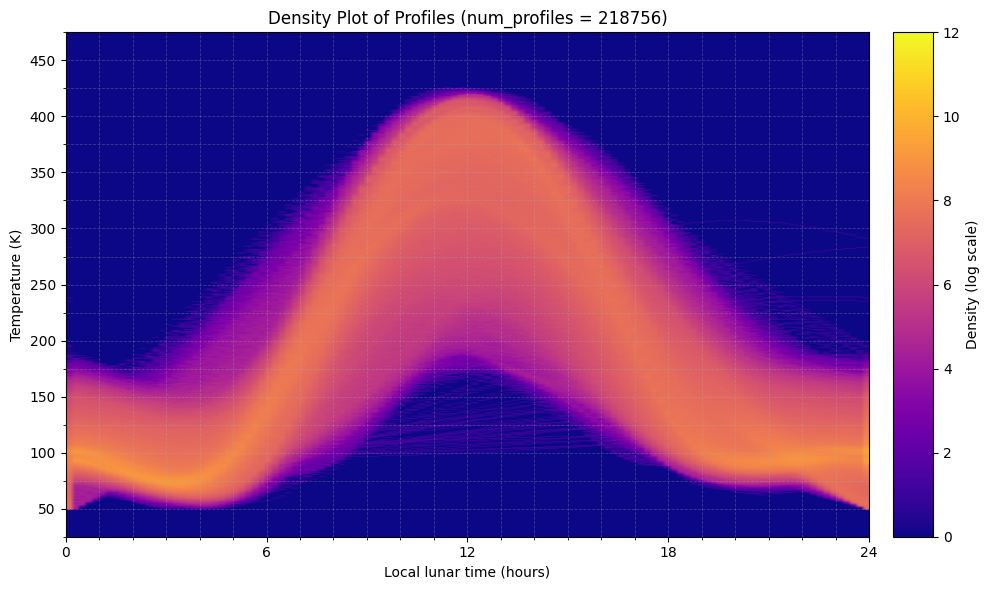

In [6]:
# * * * * * * * * * * * * * * * *
# Generate Density Plot
# * * * * * * * * * * * * * * * *
GenerateDensityPlot(temp_data, model_dir)

In [7]:
# * * * * * * * * * * * * * * * *
# Load Original Profile List
# * * * * * * * * * * * * * * * *
original_profile_list = LoadProfileList(ORIGINAL_PROFILE_LIST_JSON)

Saved figure to /workspace/outputs/profiles_v1_experiment_7_20250331_0332/histogram_max_temp.png


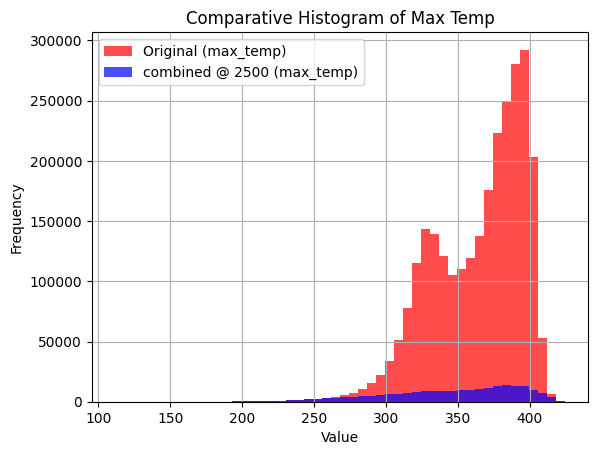

Saved figure to /workspace/outputs/profiles_v1_experiment_7_20250331_0332/histogram_min_temp.png


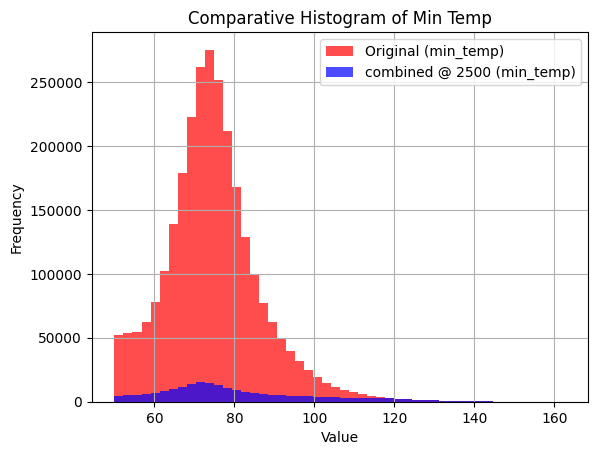

Saved figure to /workspace/outputs/profiles_v1_experiment_7_20250331_0332/histogram_mean_temp.png


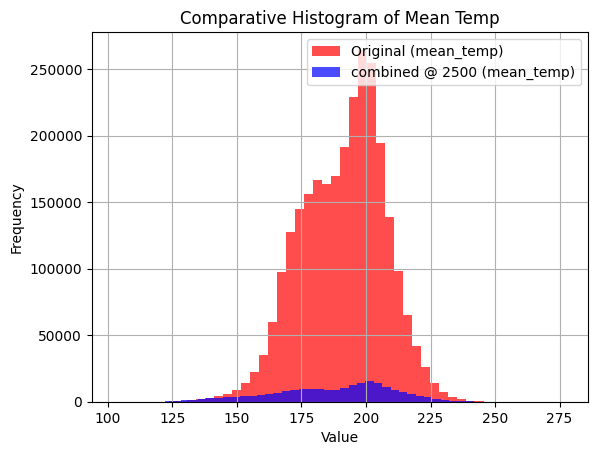

Saved figure to /workspace/outputs/profiles_v1_experiment_7_20250331_0332/histogram_std_temp.png


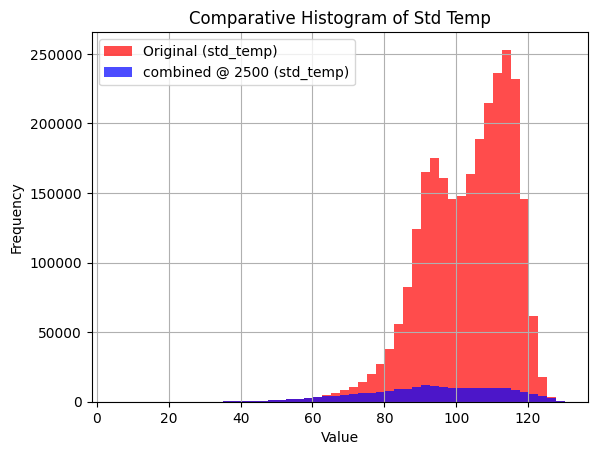

In [8]:
# * * * * * * * * * * * * * * * *
# Generate Histograms
# * * * * * * * * * * * * * * * *
statistics_original = CollectStatisticsFromProfilesV1(PROFILES_DIR, original_profile_list)
statistics_subset = CollectStatisticsFromProfilesV1(PROFILES_DIR, profile_list)
PlotComparativeHistograms(statistics_original, statistics_subset, labels=("Original", f"{TARGET_METRIC} @ {SAMPLE_SIZE}"), output_dir=model_dir)

In [9]:
# * * * * * * * * * * * * * * * *
# Training Log
# * * * * * * * * * * * * * * * 
log_filepath = os.path.join(model_dir, 'training.log')

# * * * * * * * * * * * * * * * *
# Data Prep
# * * * * * * * * * * * * * * * *
x_data_mean, x_data_std, x_data_min, x_data_max = GetDataMetrics(temp_data)

PrintAndLog(log_filepath, "Data Metrics:\n")
PrintAndLog(log_filepath, f"\tMean: {x_data_mean:.4f}\n")
PrintAndLog(log_filepath, f"\tSTD: {x_data_std:.4f}\n")
PrintAndLog(log_filepath, f"\tMin Temp: {x_data_min:.4f}\n")
PrintAndLog(log_filepath, f"\tMax Temp: {x_data_max:.4f}\n")

# Normalize Data (Mean=0, STD=1)
scaler = StandardScaler()
train_loader, val_loader, test_loader = SplitAndNormalizeData(
	temp_data, scaler, BATCH_SIZE, DEVICE)

PrintAndLog(log_filepath, "Datasets:\n")
PrintAndLog(
	log_filepath,
	f"\tTraining Data: {len(train_loader.dataset)}\n")
PrintAndLog(
	log_filepath,
	f"\tValidation Data: {len(val_loader.dataset)}\n")
PrintAndLog(log_filepath, f"\tTest Data: {len(test_loader.dataset)}\n")

Data Metrics:
Mean: 187.3971
STD: 98.0669
Min Temp: 50.0000
Max Temp: 424.9460
Datasets:
Training Data: 153129
Validation Data: 43751
Test Data: 21876


In [10]:
# * * * * * * * * * * * * * * * *
# VAE Setup
# * * * * * * * * * * * * * * * *
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=GAMMA)

summary(vae, input_size=(BATCH_SIZE, INPUT_DIM[0], INPUT_DIM[1]))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [200, 1, 120]             --
├─Encoder: 1-1                           [200, 4, 1]               --
│    └─Wrap1d: 2-1                       [200, 1, 122]             --
│    └─ConstantPad1d: 2-2                [200, 1, 128]             --
│    └─Conv1d: 2-3                       [200, 32, 128]            128
│    └─BatchNorm1d: 2-4                  [200, 32, 128]            64
│    └─Conv1d: 2-5                       [200, 32, 64]             2,080
│    └─BatchNorm1d: 2-6                  [200, 32, 64]             64
│    └─Conv1d: 2-7                       [200, 32, 32]             2,080
│    └─BatchNorm1d: 2-8                  [200, 32, 32]             64
│    └─Conv1d: 2-9                       [200, 32, 16]             2,080
│    └─BatchNorm1d: 2-10                 [200, 32, 16]             64
│    └─Conv1d: 2-11                      [200, 32, 8]              2,080
│ 

In [ ]:
# * * * * * * * * * * * * * * * *
# Train and Validate
# * * * * * * * * * * * * * * * *
losses = train(
	vae, train_loader, val_loader,
	optimizer, scheduler, DEVICE, EPOCHS,
	BETA, model_dir)

[Training] Epoch 1/100: 100%|██████████| 766/766 [00:24<00:00, 31.82it/s, best_loss=0.5803]


[Training] Epoch 1/100, L1 Loss: 0.6181, L2 Loss: 0.6426, KL Loss: 0.4616, LR: 0.001000


[Validation] Epoch 1/100: 100%|██████████| 219/219 [00:01<00:00, 113.27it/s]


[Validation] Epoch 1/100, Val L1 Loss: 0.5492, Val L2 Loss: 0.5439, Val KL Loss: 0.5303
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_7_20250331_0332'


[Training] Epoch 2/100: 100%|██████████| 766/766 [00:24<00:00, 31.21it/s, best_loss=0.5608]


[Training] Epoch 2/100, L1 Loss: 0.5801, L2 Loss: 0.5821, KL Loss: 0.5336, LR: 0.000100


[Validation] Epoch 2/100: 100%|██████████| 219/219 [00:01<00:00, 113.82it/s]


[Validation] Epoch 2/100, Val L1 Loss: 0.5444, Val L2 Loss: 0.5395, Val KL Loss: 0.5256
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_7_20250331_0332'


[Training] Epoch 3/100: 100%|██████████| 766/766 [00:25<00:00, 30.42it/s, best_loss=0.5579]


[Training] Epoch 3/100, L1 Loss: 0.5786, L2 Loss: 0.5802, KL Loss: 0.5375, LR: 0.000010


[Validation] Epoch 3/100: 100%|██████████| 219/219 [00:02<00:00, 95.72it/s] 


[Validation] Epoch 3/100, Val L1 Loss: 0.5410, Val L2 Loss: 0.5362, Val KL Loss: 0.5361
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_7_20250331_0332'


[Training] Epoch 4/100: 100%|██████████| 766/766 [00:24<00:00, 30.84it/s, best_loss=0.5604]


[Training] Epoch 4/100, L1 Loss: 0.5781, L2 Loss: 0.5795, KL Loss: 0.5378, LR: 0.000001


[Validation] Epoch 4/100: 100%|██████████| 219/219 [00:01<00:00, 114.70it/s]


[Validation] Epoch 4/100, Val L1 Loss: 0.5434, Val L2 Loss: 0.5384, Val KL Loss: 0.5331


[Training] Epoch 5/100: 100%|██████████| 766/766 [00:24<00:00, 31.24it/s, best_loss=0.5613]


[Training] Epoch 5/100, L1 Loss: 0.5785, L2 Loss: 0.5800, KL Loss: 0.5376, LR: 0.000000


[Validation] Epoch 5/100: 100%|██████████| 219/219 [00:01<00:00, 114.49it/s]


[Validation] Epoch 5/100, Val L1 Loss: 0.5431, Val L2 Loss: 0.5381, Val KL Loss: 0.5307


[Training] Epoch 6/100: 100%|██████████| 766/766 [00:25<00:00, 29.88it/s, best_loss=0.5830]


[Training] Epoch 6/100, L1 Loss: 0.5781, L2 Loss: 0.5796, KL Loss: 0.5375, LR: 0.000000


[Validation] Epoch 6/100: 100%|██████████| 219/219 [00:02<00:00, 104.58it/s]


[Validation] Epoch 6/100, Val L1 Loss: 0.5445, Val L2 Loss: 0.5392, Val KL Loss: 0.5290


[Training] Epoch 7/100: 100%|██████████| 766/766 [00:25<00:00, 30.47it/s, best_loss=0.5671]


[Training] Epoch 7/100, L1 Loss: 0.5781, L2 Loss: 0.5795, KL Loss: 0.5376, LR: 0.000000


[Validation] Epoch 7/100: 100%|██████████| 219/219 [00:02<00:00, 98.63it/s] 


[Validation] Epoch 7/100, Val L1 Loss: 0.5417, Val L2 Loss: 0.5368, Val KL Loss: 0.5370


[Training] Epoch 8/100: 100%|██████████| 766/766 [00:24<00:00, 31.84it/s, best_loss=0.5760]


[Training] Epoch 8/100, L1 Loss: 0.5782, L2 Loss: 0.5796, KL Loss: 0.5376, LR: 0.000000


[Validation] Epoch 8/100: 100%|██████████| 219/219 [00:01<00:00, 109.98it/s]


[Validation] Epoch 8/100, Val L1 Loss: 0.5423, Val L2 Loss: 0.5372, Val KL Loss: 0.5396


[Training] Epoch 9/100: 100%|██████████| 766/766 [00:24<00:00, 31.69it/s, best_loss=0.5757]


[Training] Epoch 9/100, L1 Loss: 0.5782, L2 Loss: 0.5796, KL Loss: 0.5376, LR: 0.000000


[Validation] Epoch 9/100: 100%|██████████| 219/219 [00:01<00:00, 110.72it/s]


[Validation] Epoch 9/100, Val L1 Loss: 0.5406, Val L2 Loss: 0.5357, Val KL Loss: 0.5396
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_7_20250331_0332'


[Training] Epoch 10/100: 100%|██████████| 766/766 [00:24<00:00, 31.69it/s, best_loss=0.5615]


[Training] Epoch 10/100, L1 Loss: 0.5781, L2 Loss: 0.5794, KL Loss: 0.5376, LR: 0.000000


[Validation] Epoch 10/100: 100%|██████████| 219/219 [00:01<00:00, 109.61it/s]


[Validation] Epoch 10/100, Val L1 Loss: 0.5427, Val L2 Loss: 0.5378, Val KL Loss: 0.5365


[Training] Epoch 11/100: 100%|██████████| 766/766 [00:23<00:00, 31.99it/s, best_loss=0.5714]


[Training] Epoch 11/100, L1 Loss: 0.5783, L2 Loss: 0.5797, KL Loss: 0.5375, LR: 0.000000


[Validation] Epoch 11/100: 100%|██████████| 219/219 [00:01<00:00, 111.95it/s]


[Validation] Epoch 11/100, Val L1 Loss: 0.5411, Val L2 Loss: 0.5363, Val KL Loss: 0.5371


[Training] Epoch 12/100: 100%|██████████| 766/766 [00:24<00:00, 31.58it/s, best_loss=0.5647]


[Training] Epoch 12/100, L1 Loss: 0.5782, L2 Loss: 0.5797, KL Loss: 0.5376, LR: 0.000000


[Validation] Epoch 12/100: 100%|██████████| 219/219 [00:02<00:00, 108.34it/s]


[Validation] Epoch 12/100, Val L1 Loss: 0.5437, Val L2 Loss: 0.5387, Val KL Loss: 0.5279


[Training] Epoch 13/100:  44%|████▍     | 340/766 [00:10<00:13, 30.87it/s, best_loss=0.5857]

In [ ]:
# * * * * * * * * * * * * * * * *
# Plot Losses
# * * * * * * * * * * * * * * * *
PlotLosses(losses, EPOCHS, model_dir)
SaveLossesToCSV(losses, os.path.join(model_dir, "losses.csv"))

In [ ]:
# * * * * * * * * * * * * * * * *
# Best Validation Loss
# * * * * * * * * * * * * * * * *
PrintAndLog(log_filepath, "Best Validation Loss in Kelvins:\n")
PrintAndLog(
	log_filepath,
	f"\t{min(losses['val_l1_losses'])*x_data_std:.4f} K\n")

In [ ]:
# * * * * * * * * * * * * * * * *
# Sample
# * * * * * * * * * * * * * * * *
z_sample = SampleLatentSpace(
	vae,
	test_loader,
	scaler,
	DEVICE,
	model_dir
)

In [ ]:
# * * * * * * * * * * * * * * * *
# Analyze Latent Space
# * * * * * * * * * * * * * * * *
mean_latent_vals = GetMeanLatentValues(z_sample, LATENT_DIM)
for i in range(LATENT_DIM):
	print(f"z{i}: {mean_latent_vals[i]:.4f}")

VisualizeLatentSpace(
	vae, LATENT_DIM, z_sample,
	scaler, DEVICE, model_dir)